# 7_Filtros: Elección de la Frecuencia de Multirate

Como se explico en el notbook anterior se tratara de buscar la mejor frecuencia de resampleo, con la cual podamos reducir considerablemente el tiempo de procesamiento del filtrado por mediana movil pero sin dejar de descuidar la buena estimación de la linea de base, que al fin y al cabo es el objetivo principal.

El primer paso a realizar es la estimacion de la linea de base con el metodo de Mediana Movil como parametro con el cual comparar las siguientes estimaciones

In [61]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,12)
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as sig
import time
import scipy.interpolate as interpol


#------APERTURA DE LA SEÑAL-------
mat_struct = sio.loadmat('/home/luciasucunza/git_proyecto_ecg/Filtros/TP4_ecg.mat')

ecg_one_lead  = mat_struct['ecg_lead']
ecg_one_lead  = ecg_one_lead.flatten(1)
cant_muestras = len(ecg_one_lead)

fs       = 1000 
nyq_frec = fs / 2
t        = np.arange(cant_muestras) / fs

In [19]:
#------OBTENCION DE LA BASELINE POR MEDIANA MOVIL-------
to_todo = time.time()

baseline = sig.medfilt (ecg_one_lead, kernel_size = int (np.around(fs*0.5*0.2)    *2 +1  ))
baseline = sig.medfilt (baseline, kernel_size = int (np.around(fs*0.5*0.6)    *2 +1  )) 
baseline = sig.medfilt (baseline, kernel_size = int (np.around(fs*0.5*(1/50)) *2 +1  ))

tf_todo = time.time()

Ya que anteriormente el resampleo a 25Hz fue excesivo se probaran los resampleos a 500Hz, 100Hz y 50Hz

In [20]:
#------        500Hz         -------
#------Parametros de Diezmado-------
to_500 = time.time() 

f_B         = 7

fs_old_1    = fs
fs_new_1    = 500
nyq_frec_1  = fs_old_1/2

fs_old_3    = fs_new_1
fs_new_3    = fs_old_1
nyq_frec_3  = fs_old_3/2

D   = int(fs_old_1 / fs_new_1)

#------Diseño del Filtro-------
ripple = -0.05
atenua = -40.

wpb_p_1         = f_B               #Hz
wpb_s_1         = nyq_frec_1/D      #Hz
cant_coef_1     = 151

frecs_pb_1    = np.array([0.0,    wpb_p_1,  wpb_s_1,  nyq_frec_1 ])
gainsDB_pb_1  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_1    = 10**(gainsDB_pb_1/20)

fir_coeff_pb_1       = sig.firls( cant_coef_1, frecs_pb_1, gains_pb_1, fs=fs_old_1 )
w_pb_1, hh_pb_1     = sig.freqz( fir_coeff_pb_1, 1 )
w_pb_1              = w_pb_1 / np.pi * nyq_frec

#------ Filtrado-------
ECG_Filt_1 = sig.lfilter(fir_coeff_pb_1, 1, ecg_one_lead)

#------LPF 10-------
ECG_Diez_1 = np.zeros(int(cant_muestras/D), dtype=float)

for i in range(int(cant_muestras/D)) :
        ECG_Diez_1[i] = ECG_Filt_1[i*D]

#------Region de Trabajo-------
c_muestras_zoom = i+1

zoom_region     = np.arange(0, c_muestras_zoom , 1)
ecg_zoom        = ECG_Diez_1
t_zoom          = t[zoom_region]

#------Estimacion de la Linea de Base-------
baseline_BF = sig.medfilt (ecg_zoom, kernel_size = int (np.around(fs*0.5*0.2)    *2 +1  ))
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*0.6)    *2 +1  )) 
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*(1/50)) *2 +1  ))

#------ Interpolacion -------
n_new                       = np.arange( cant_muestras )

ni                          = np.zeros( len(baseline_BF)+1 )
ni[0:len(baseline_BF)]      = range(int(cant_muestras/D))
ni[0:len(baseline_BF)]      = ni[0:len(baseline_BF)]*D
ni[len(baseline_BF)]        = cant_muestras -1

baseline_BF_aux                         = np.zeros( len(baseline_BF)+1 )
baseline_BF_aux[0:len(baseline_BF)]     = baseline_BF

f = interpol.interp1d( ni, baseline_BF_aux,       kind='cubic')
baseline_AF = f(n_new)

#------Diseño de Filtro-------
ripple = -0.05
atenua = -40.

wpb_p_3         = 0.2               #Hz
wpb_s_3         = nyq_frec_3/D        #Hz
cant_coef_3     = 151

frecs_pb_3    = np.array([0.0,    wpb_p_3,  wpb_s_3,  nyq_frec_3 ])
gainsDB_pb_3  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_3    = 10**(gainsDB_pb_3/20)

fir_coeff_pb_3       = sig.firls( cant_coef_3, frecs_pb_3, gains_pb_3, fs=fs_old_3 )
w_pb_3, hh_pb_3      = sig.freqz( fir_coeff_pb_3, 1 )
w_pb_3               = w_pb_3 / np.pi * nyq_frec

#------ Filtrado-------
baseline_500 = sig.lfilter(fir_coeff_pb_3, 1, baseline_AF)

tf_500 = time.time()

In [21]:
#------        100Hz         -------
#------Parametros de Diezmado-------
to_100 = time.time() 

f_B         = 7

fs_old_1    = fs
fs_new_1    = 100
nyq_frec_1  = fs_old_1/2

fs_old_3    = fs_new_1
fs_new_3    = fs_old_1
nyq_frec_3  = fs_old_3/2

D   = int(fs_old_1 / fs_new_1)

#------Diseño del Filtro-------
ripple = -0.05
atenua = -40.

wpb_p_1         = f_B               #Hz
wpb_s_1         = nyq_frec_1/D      #Hz
cant_coef_1     = 151

frecs_pb_1    = np.array([0.0,    wpb_p_1,  wpb_s_1,  nyq_frec_1 ])
gainsDB_pb_1  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_1    = 10**(gainsDB_pb_1/20)

fir_coeff_pb_1       = sig.firls( cant_coef_1, frecs_pb_1, gains_pb_1, fs=fs_old_1 )
w_pb_1, hh_pb_1     = sig.freqz( fir_coeff_pb_1, 1 )
w_pb_1              = w_pb_1 / np.pi * nyq_frec

#------ Filtrado-------
ECG_Filt_1 = sig.lfilter(fir_coeff_pb_1, 1, ecg_one_lead)

#------LPF 10-------
ECG_Diez_1 = np.zeros(int(cant_muestras/D), dtype=float)

for i in range(int(cant_muestras/D)) :
        ECG_Diez_1[i] = ECG_Filt_1[i*D]

#------Region de Trabajo-------
c_muestras_zoom = i+1

zoom_region     = np.arange(0, c_muestras_zoom , 1)
ecg_zoom        = ECG_Diez_1
t_zoom          = t[zoom_region]

#------Estimacion de la Linea de Base-------
baseline_BF = sig.medfilt (ecg_zoom, kernel_size = int (np.around(fs*0.5*0.2)    *2 +1  ))
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*0.6)    *2 +1  )) 
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*(1/50)) *2 +1  ))

#------ Interpolacion -------
n_new                       = np.arange( cant_muestras )

ni                          = np.zeros( len(baseline_BF)+1 )
ni[0:len(baseline_BF)]      = range(int(cant_muestras/D))
ni[0:len(baseline_BF)]      = ni[0:len(baseline_BF)]*D
ni[len(baseline_BF)]        = cant_muestras -1

baseline_BF_aux                         = np.zeros( len(baseline_BF)+1 )
baseline_BF_aux[0:len(baseline_BF)]     = baseline_BF

f = interpol.interp1d( ni, baseline_BF_aux,       kind='cubic')
baseline_AF = f(n_new)

#------Diseño de Filtro-------
ripple = -0.05
atenua = -40.

wpb_p_3         = 0.2               #Hz
wpb_s_3         = nyq_frec_3/D        #Hz
cant_coef_3     = 151

frecs_pb_3    = np.array([0.0,    wpb_p_3,  wpb_s_3,  nyq_frec_3 ])
gainsDB_pb_3  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_3    = 10**(gainsDB_pb_3/20)

fir_coeff_pb_3       = sig.firls( cant_coef_3, frecs_pb_3, gains_pb_3, fs=fs_old_3 )
w_pb_3, hh_pb_3      = sig.freqz( fir_coeff_pb_3, 1 )
w_pb_3               = w_pb_3 / np.pi * nyq_frec

#------ Filtrado-------
baseline_100 = sig.lfilter(fir_coeff_pb_3, 1, baseline_AF)

tf_100 = time.time()

In [22]:
#------         50Hz         -------
#------Parametros de Diezmado-------
to_50 = time.time()

f_B         = 7

fs_old_1    = fs
fs_new_1    = 200
nyq_frec_1  = fs_old_1/2

fs_old_2    = fs_new_1
fs_new_2    = 50
nyq_frec_2  = fs_old_2/2

fs_old_3    = fs_new_2
fs_new_3    = fs_old_1
nyq_frec_3  = fs_old_3/2


D   = int(fs_old_1 / fs_new_2)
D1  = int(fs_old_1 / fs_new_1)
D2  = int(fs_old_2 / fs_new_2)


#%%
#------Diseños de Filtros-------
ripple = -0.05
atenua = -40.

#------LPF 10-------
wpb_p_1         = f_B               #Hz
wpb_s_1         = nyq_frec_1/D1     #Hz
cant_coef_1     = 151

frecs_pb_1    = np.array([0.0,    wpb_p_1,  wpb_s_1,  nyq_frec_1 ])
gainsDB_pb_1  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_1    = 10**(gainsDB_pb_1/20)

fir_coeff_pb_1       = sig.firls( cant_coef_1, frecs_pb_1, gains_pb_1, fs=fs_old_1 )
w_pb_1, hh_pb_1     = sig.freqz( fir_coeff_pb_1, 1 )
w_pb_1              = w_pb_1 / np.pi * nyq_frec

#------LPF 4-------
wpb_p_2         = f_B           #Hz
wpb_s_2         = nyq_frec_2/D2 #Hz
cant_coef_2     = 41

frecs_pb_2    = np.array([0.0,    wpb_p_2,  wpb_s_2,  nyq_frec_2 ])
gainsDB_pb_2  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_2    = 10**(gainsDB_pb_2/20)

fir_coeff_pb_2      = sig.firls( cant_coef_2, frecs_pb_2, gains_pb_2, fs=fs_old_2)       
w_pb_2, hh_pb_2     = sig.freqz( fir_coeff_pb_2, 1 )
w_pb_2              = w_pb_2 / np.pi * nyq_frec

#------Primer Filtrado-------
ECG_Filt_1 = sig.lfilter(fir_coeff_pb_1, 1, ecg_one_lead)

#------LPF 10-------
ECG_Diez_1 = np.zeros(int(cant_muestras/D1), dtype=float)

for i in range(int(cant_muestras/D1)) :
        ECG_Diez_1[i] = ECG_Filt_1[i*D1]

#------Segundo Filtrado-------
ECG_Filt_2 = sig.lfilter(fir_coeff_pb_2, 1, ECG_Filt_1)

#------LPF 4-------
ECG_Diez_2 = np.zeros(int(cant_muestras/D), dtype=float)

for i in range(int(cant_muestras/D)):
        ECG_Diez_2[i] = ECG_Filt_2[i*D]

#------Region de Trabajo-------
c_muestras_zoom = i+1

zoom_region     = np.arange(0, c_muestras_zoom , 1)
ecg_zoom        = ECG_Diez_2
t_zoom          = t[zoom_region]

#------Estimacion de la Linea de Base-------
baseline_BF = sig.medfilt (ecg_zoom, kernel_size = int (np.around(fs*0.5*0.2)    *2 +1  ))
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*0.6)    *2 +1  )) 
baseline_BF = sig.medfilt (baseline_BF, kernel_size = int (np.around(fs*0.5*(1/50)) *2 +1  ))

#------ Interpolacion -------
n_new                   = np.arange( cant_muestras )

ni                          = np.zeros( len(baseline_BF)+1 )
ni[0:len(baseline_BF)]      = range(int(cant_muestras/D))
ni[0:len(baseline_BF)]      = ni[0:len(baseline_BF)]*D
ni[len(baseline_BF)]        = cant_muestras -1

baseline_BF_aux                         = np.zeros( len(baseline_BF)+1 )
baseline_BF_aux[0:len(baseline_BF)]     = baseline_BF

f = interpol.interp1d( ni, baseline_BF_aux,       kind='cubic')
baseline_AF = f(n_new)

#------Diseño de Filtro-------
ripple = -0.05
atenua = -40.

#------LPF 10-------
wpb_p_3         = 0.2               #Hz
wpb_s_3         = nyq_frec_3/D        #Hz
cant_coef_3     = 151

frecs_pb_3    = np.array([0.0,    wpb_p_3,  wpb_s_3,  nyq_frec_3 ])
gainsDB_pb_3  = np.array([ripple, ripple, atenua, atenua   ])
gains_pb_3    = 10**(gainsDB_pb_3/20)

fir_coeff_pb_3       = sig.firls( cant_coef_3, frecs_pb_3, gains_pb_3, fs=fs_old_3 )
w_pb_3, hh_pb_3      = sig.freqz( fir_coeff_pb_3, 1 )
w_pb_3               = w_pb_3 / np.pi * nyq_frec

#------Primer Filtrado-------
baseline_50 = sig.lfilter(fir_coeff_pb_3, 1, baseline_AF)

tf_50 = time.time()

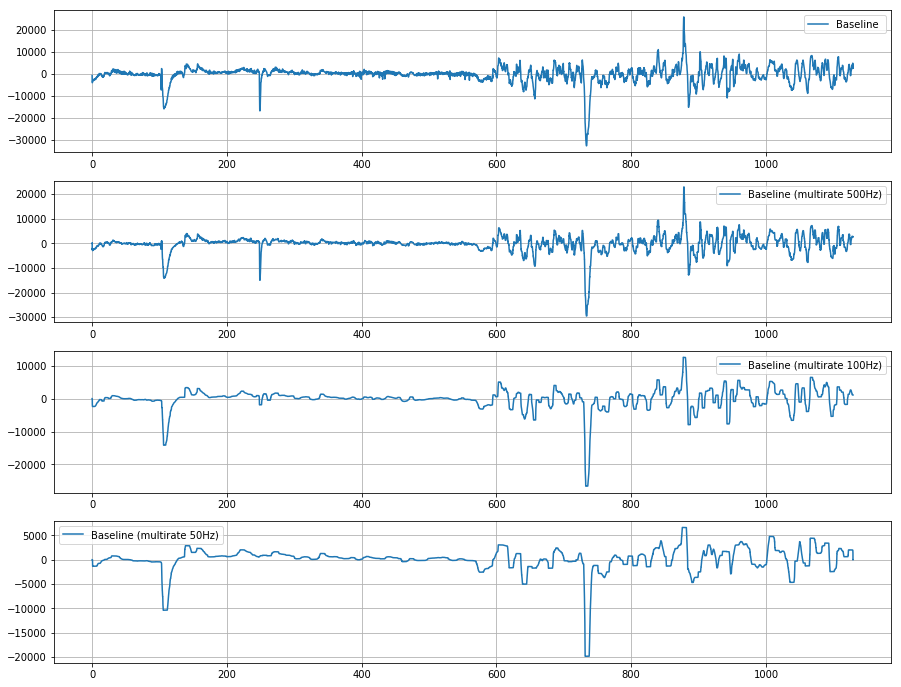

In [63]:
plt.figure(3)
plt.title('Señales')
plt.subplot(411)
plt.plot(t, baseline,     label='Baseline ')
plt.grid()
plt.legend()
plt.subplot(412)
plt.plot(t, baseline_500, label='Baseline (multirate 500Hz)')
plt.grid()
plt.legend()
plt.subplot(413)
plt.plot(t, baseline_100, label='Baseline (multirate 100Hz)')
plt.grid()
plt.legend()
plt.subplot(414)
plt.plot(t, baseline_50,  label='Baseline (multirate 50Hz)' )
plt.grid()
plt.legend()
plt.show()

In [35]:
#------Comparación de las estimaciones-------

dt_todo = round(tf_todo - to_todo,2) 
dt_500 = round(tf_500 - to_500,2) 
dt_100 = round(tf_100 - to_100,2)
dt_50  = round(tf_50  - to_50 ,2) 

print ("\n")
print('Porcentaje de error en la estimacion y tiempo de procesamiento de toda la señal:')
print ("\n")
print('           ' + str( round(0,2)  ) + '%' + '              ' +  str(dt_todo) + 's' )
print ("\n")
print('Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 500):')
print ("\n")
print('           ' + str( round(error_500_p,2)  ) + '%' + '           ' +  str(dt_500) + 's' )
print ("\n")
print('Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 100):')
print ("\n")
print('           ' + str( round(error_100_p,2)  ) + '%' + '           ' +  str(dt_100) + 's' )
print ("\n")
print('Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 50):' )
print ("\n")
print('           ' + str( round(error_50_p,2)   ) + '%' + '           ' +  str(dt_50) + 's' )



Porcentaje de error en la estimacion y tiempo de procesamiento de toda la señal:


           0%              47.89s


Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 500):


           2.79%           24.63s


Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 100):


           12.08%           5.71s


Porcentaje de error en la estimacion y tiempo de procesamiento (resampleada a 50):


           35.95%           3.39s


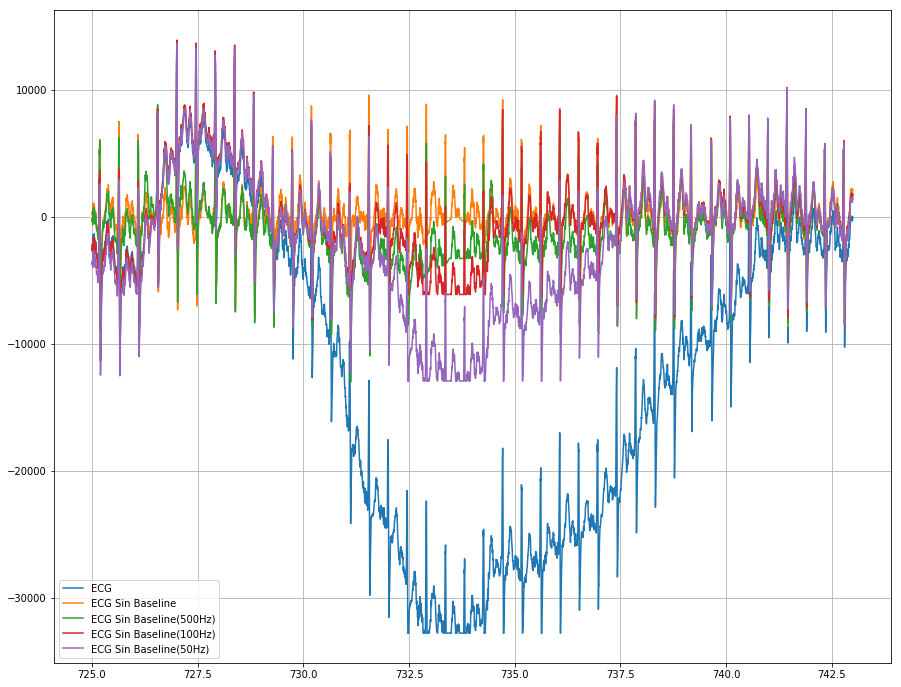

In [62]:
ecg_F     = ecg_one_lead - baseline
ecg_F_500 = ecg_one_lead - baseline_500
ecg_F_100 = ecg_one_lead - baseline_100
ecg_F_50  = ecg_one_lead - baseline_50


zoom_region = np.arange( 725000, 743000, dtype='uint')
    
plt.plot(t[zoom_region], ecg_one_lead[zoom_region], label='ECG')
plt.plot(t[zoom_region], ecg_F[zoom_region],        label='ECG Sin Baseline'    )
plt.plot(t[zoom_region], ecg_F_500[zoom_region],    label='ECG Sin Baseline(500Hz)')
plt.plot(t[zoom_region], ecg_F_100[zoom_region],    label='ECG Sin Baseline(100Hz)')
plt.plot(t[zoom_region], ecg_F_50[zoom_region],     label='ECG Sin Baseline(50Hz)')

plt.legend()
plt.grid()
plt.show()